## Análise : Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online
### Meta: Entender se as avaliações de usuários (reviews) fazem ou não diferença para o usuário efetuar uma compra no portal. Para isso efetuaremos o Teste A/B no conjunto de dados.

### Execução de 5 passos para analisar o Teste A/B:

1. Configurar o experimento.

2. Executar o teste de hipóteses e registrar a taxa de sucesso de cada grupo.

3. Criar o Plot da distribuição da diferença entre as duas amostras.

4. Calculando o poder estatístico.

5. Avaliar como o tamanho das amostras afeta os Testes A/B.

### Dicionário:
- Variante A(grupo controle): Mostra o número atual de comentários e avaliações de usuários
- Variante B(grupo teste): Não mostra os comentários de usuários no site.

In [1]:
# Importação dos pacotes
import pandas as pd
import numpy as np
import datetime 
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as scs

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1, figsize = (15, 6))
%matplotlib inline

### Carregando os dados

In [2]:
df_vendas = pd.read_csv("dados/dataset.csv")

In [3]:
df_vendas.head()

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


In [4]:
df_vendas.tail()

,id,variante,compra,data
54995,0x451451,A,False,2019-06-19
54996,0x871d51,A,False,2019-03-22
54997,0x50d163,A,False,2019-02-10
54998,0x3544c4,B,False,2020-01-09
54999,0x983331,A,False,2019-09-05


### Análise Exploratória

In [5]:
df_vendas.shape

(55000, 4)

In [6]:
df_vendas.dtypes

id          object
variante    object
compra        bool
data        object
dtype: object

In [7]:
df_vendas['data'].min()

'2019-01-01'

In [8]:
df_vendas['data'].max()

'2020-01-30'

In [9]:
df_vendas.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [10]:
# Verificando se tem ID duplicado
df_vendas.id.value_counts().count()

55000

In [11]:
# Verifica quantidade de registros para cada opção da variável 'compra'
df_vendas.compra.value_counts()

False    46416
True      8584
Name: compra, dtype: int64

In [12]:
# Proporção das variantes mostradas para os usuários
df_vendas.variante.value_counts()

A    50000
B     5000
Name: variante, dtype: int64

In [13]:
# Probabilidade de um usuário visualizar a variante A
df_vendas[df_vendas.variante == 'A'].shape[0]/df_vendas.shape[0] * 100

90.9090909090909

In [14]:
# Probabilidade de um usuário visualizar a variante B
df_vendas[df_vendas.variante == 'B'].shape[0]/df_vendas.shape[0] * 100

9.090909090909092

In [15]:
# Total de compras realizadas quando a variante = A
df_vendas[df_vendas.variante == 'A'].compra.sum()

7603

In [16]:
# Total de compras realizadas quando a variante = B
df_vendas[df_vendas.variante == 'B'].compra.sum()

981

In [17]:
# Probabilidade de conversão independente da variante recebida
df_vendas.compra.mean()

0.15607272727272728

In [18]:
# Probabilidade de conversão para usuário do grupo A
df_vendas[df_vendas.variante == 'A'].compra.mean()

0.15206

In [19]:
# Probabilidade de conversão para usuário do grupo B
df_vendas[df_vendas.variante == 'B'].compra.mean()

0.1962

A probabilidade de um usuário utilizar o grupo de teste é de 10% e a probabilidade de vendas do grupo de teste é de 19%. 

### Passo 1: Configurando o Experimento

### Definindo as Hipóteses para o Teste A/B
- Hipótese Nula: PB - PA = 0 (Lê-se: Probabilidade de B menos probabilidade de A é igual a zero. Essa hipótese diz que mostrar ou não as avaliações, não teve impacto no poder de compra do usuário)
- Hipótese Alternativa: PB - PA > 0 (Lê-se: Probabilidade de B menos probabilidade de A é maior que zero. Essa hipótese diz que a variante B terá um efeito diferente da variante A, ou seja, há diferença se mostrar ou não as avaliações nas páginas)

### Pré-Processamento dos Dados

In [20]:
def extrai_data(x):
    return x[:7]

In [21]:
df_vendas['ano_mes'] = df_vendas['data'].apply(extrai_data)

In [22]:
df_vendas.head()

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [23]:
df_vendas_2020 = df_vendas[df_vendas['ano_mes'] == '2020-01']

In [24]:
df_vendas_2020.head()

,id,variante,compra,data,ano_mes
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01


In [25]:
df_vendas_2020.shape

(8821, 5)

### Criação do Baseline

In [26]:
df_ab = df_vendas_2020[['variante', 'compra']]

In [27]:
df_ab.columns = ['grupo', 'conversao']

In [28]:
df_ab.head()

,grupo,conversao
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [29]:
# Tabela pivot
df_ab_sum = df_ab.pivot_table(values = 'conversao', index = 'grupo', aggfunc = np.sum)

In [30]:
df_ab_sum.head()

,conversao
grupo,
A,587.0
B,981.0


In [31]:
# Sumário com total
df_ab_sum['total'] = df_ab.pivot_table(values = 'conversao', index = 'grupo', aggfunc = lambda x: len(x))

In [32]:
# Sumário com taxa
df_ab_sum['taxa'] = df_ab.pivot_table(values = 'conversao', index = 'grupo')

In [33]:
df_ab_sum.head()

,conversao,total,taxa
grupo,,,
A,587.0,3821,0.153625
B,981.0,5000,0.196200


In [34]:
conversao_A = df_ab_sum['conversao'][0]
total_A = df_ab_sum['total'][0]
taxa_A = df_ab_sum['taxa'][0]

conversao_B = df_ab_sum['conversao'][1]
total_B = df_ab_sum['total'][1]
taxa_B = df_ab_sum['taxa'][1]

In [35]:
conversao_base = taxa_A

In [36]:
conversao_base

0.15362470557445695

In [37]:
# Efeito mínimo detectável(nível de significância)
efeito_min = taxa_B - taxa_A

In [38]:
efeito_min

0.04257529442554306

### Passo 2: Execução do Teste de Hipótese

- Alfa(Nível de significância): normalmente 5%; probabilidade de rejeitar a hipótese nula quando a hipótese nula for verdadeira

- Beta: probabilidade de aceitar a hipótese nula quando a hipótese nula é realmente falsa.
- p: probabilidade

In [39]:
# Parâmetros que usaremos para executar o teste
alfa = 0.05
beta = 0.2

In [40]:
# Tamanho da amostra
n = 50000

In [41]:
# Teste Binomial(usando padrão de 5% para nível de significância)
teste_binom = scs.binom(n, p = conversao_base)

In [42]:
# Teste binomial com efeito mínimo( nível de significância de 0.04)
teste_binom_min = scs.binom(n, p = taxa_B)

<BarContainer object of 50001 artists>

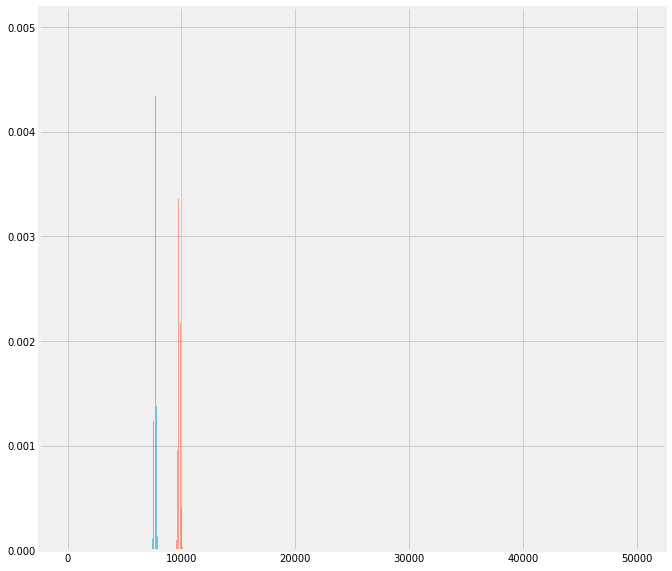

In [43]:
# probability mass function (pmf)
# Plot

# Área de plotagem
fig, ax = plt.subplots(figsize=(10, 10))

# Definição de valores para x
x = np.linspace(0, int(n), int(n) + 1)

# Resultados mostrados com a pmf e alfa de 0.5
ax.bar(x, teste_binom.pmf(x), alpha = 0.5)
ax.bar(x, teste_binom_min.pmf(x), alpha = 0.5)

Observação do gráfico: a variante B (representada pela linha vermelha) apresentou um maior número de conversão do que a variante A (representada pela linha azul), porém o pico da variante A indica que tem uma maior probabilidade para conversão.

### Passo 3: Plot da Distribuição

Text(0, 0.5, 'Probabilidade')

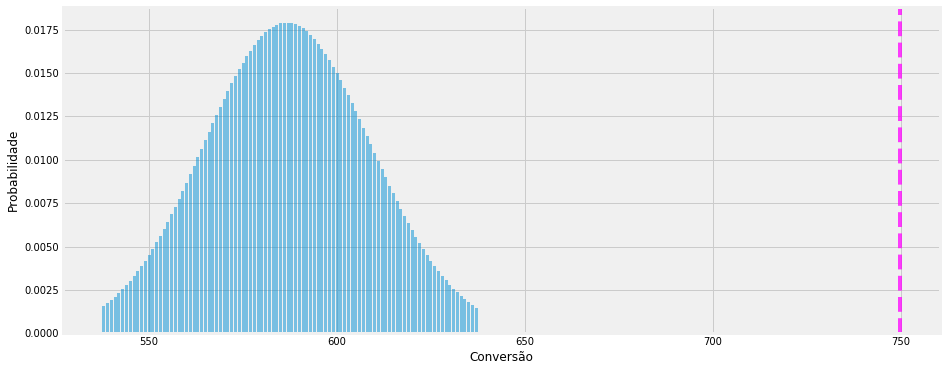

In [44]:
# Gráfico para comparar os dois grupos traçando a distribuição do grupo de controle(variante A) e calculando a probabilidade 
# de obter o resultado de nosso grupo de teste(variante B).

# Plot da distribuição da variante A

# Area de plotagem
fig, ax= plt.subplots(figsize = (14, 6))

# Teste de A
x = np.linspace(conversao_A - 49, conversao_A + 50, 100)
y = scs.binom(total_A, taxa_A).pmf(x)

# Cria barra vertical
ax.bar(x,y, alpha = 0.5)
ax.axvline(x = taxa_B * total_A, c= 'magenta', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Observação do gráfico: Caso o total de usuários do grupo A fossem submetidos a taxa do grupo B, a conversão teria sido maior, em aproximadamente 750 vendas para aquele mês.

Text(0, 0.5, 'Probabilidade')

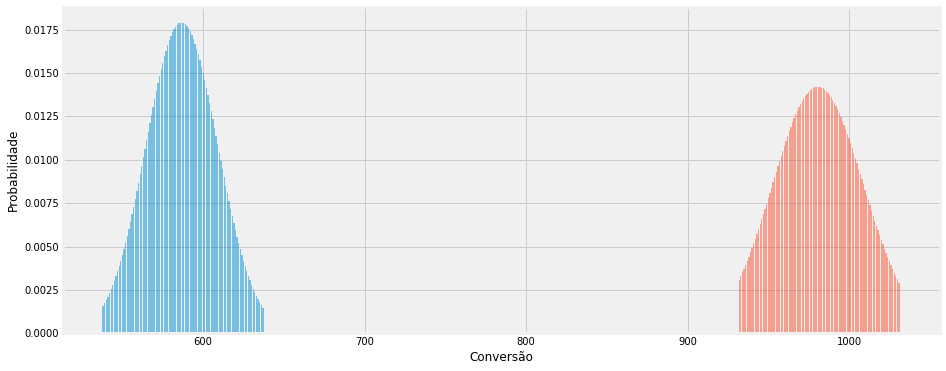

In [45]:
# Plot da distribuição das 2 variantes

# Área de plotagem 
fig, ax = plt.subplots(figsize = (14,6))

# Gráfico de A
xA = np.linspace(conversao_A - 49, conversao_A + 50, 100)
yA = scs.binom(total_A, taxa_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B
xB = np.linspace(conversao_B - 49, conversao_B + 50, 100)
yB = scs.binom(total_B, taxa_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Para fazer a comparação dos dois grupos, será utilizado a taxa de converção e assim contruir as distribuições de 
probabilidade. Será necessario padronizar os dados para comparar a probabilidade de sucesso, p para cada grupo

In [46]:
# Probabilidade(taxas de conversão)
p_A = taxa_A
p_B = taxa_B

# Número de acessos
n_A = 3821
n_B = 5000

In [47]:
# Erro padrão(standard error) para a média de ambos os grupos
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

In [48]:
print(SE_A)
print(SE_B)

0.005833423432971666
0.0056161474339621814


Text(0, 0.5, 'PDF - Probabilidade de densidade')

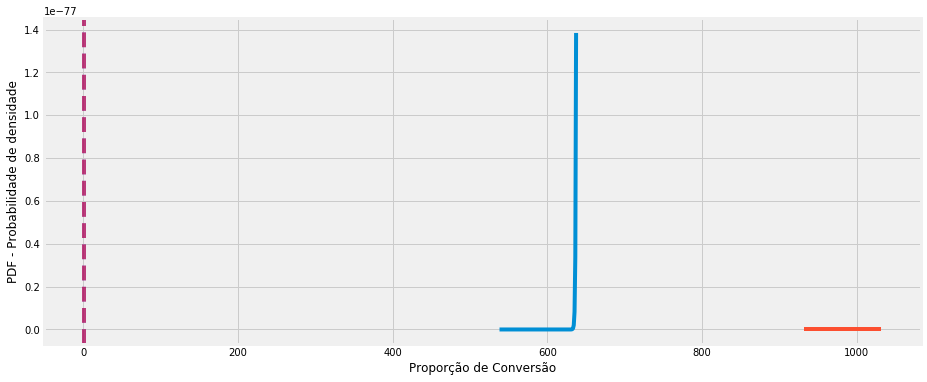

In [49]:
# Plot das distribuições das hipóteses nula e alternativa

# Area de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Dados para a variável aleatória
x = np.linspace(0, p_B - p_A, 100)

# Distribuição de A
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x = p_A, c = 'blue', alpha = 0.5, linestyle = '--')

# Distribuição de B
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x = p_B, c = 'red', alpha = 0.5, linestyle = '--')

#Labels
plt.xlabel('Proporção de Conversão')
plt.ylabel('PDF - Probabilidade de densidade')

Observação do gráfico: As linhas contínuas representam a taxa de conversão média para cada grupo. A distância entre a linha azul e a linha vermelha é igual à diferença média entre o grupo de A e B. 

### Verificando a Hipótese Nula e a Hipótese Alternativa
obs: A hipótese nula afirma que a diferença de probabilidade entre os dois grupos é zero. Portanto, a média para essa distribuição normal será zero. A outra propriedade de que precisaremos para a distribuição normal é o desvio padrão ou a variância.

- A hipótese nula será uma distribuição normal com uma média de zero e um desvio padrão igual ao erro padrão agrupado.
- A hipótese alternativa tem o mesmo desvio padrão que a hipótese nula, mas a média estará localizada na diferença na taxa de conversão, d_hat. Isso faz sentido porque podemos calcular a diferença nas taxas de conversão diretamente dos dados, mas a distribuição normal representa possíveis valores que nosso experimento poderia ter nos dado.


In [50]:
# Calcula a probabilidade agrupada
prob_agrupada = (p_A * n_A + p_B * n_B) / (n_A + n_B)

In [51]:
# Calculando z
z = (p_B - p_A)/ (prob_agrupada * (1 - prob_agrupada) * (1/n_A + 1 / n_B))**0.5
z

5.1827257006909795

In [52]:
# Verificando se z é maior que 1.64(nível de significância de 0.05)
z > 1.64

True

### Plot da Distribuição da Probabilidade
será criado por série de funções auxiliares 

In [53]:
# Função que retona a probabilidade agrupada para 2 amostras
def prob_agrupada_func(n_A, n_B, X_A, X_B):
    return( X_A + X_B)/ (n_A +n_B)

In [54]:
# Função que retorna o erro padrão agrupado para 2 amostras
def erro_padrao_agrupado_func(n_A, n_B, X_A, X_B):
    p_hat = prob_agrupada_func(n_A, n_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1- p_hat) * (1/ n_A + 1/ n_B))
    return SE

In [55]:
# Função que retorna o valor de z para determinado nível de significância
def z_val(sig_level = 0.05, two_tailed = True):
    
    # Gera distribuição para o valor z
    z_dist = scs.norm()
    
    # Verifica se devemos checar as duas caudas
    if two_tailed:
        sig_level = sig_level/2
        area = 1- sig_level
    else:
        area = 1- sig_level
        
    # Valor de z
    z = z_dist.ppf(area)
    
    return z

In [56]:
# Calcula o intervalo de confiança
def int_confianca(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    
    # Calcula o valor de z
    z = z_val(sig_level)
    
    # Limites à esquerda e direita
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)
    
    return(left, right)

In [57]:
# Função que calcula o intervalo de confiança de duas caldas
def plot_IC(ax, mu, s, sig_level = 0.05, color = 'grey'):
    
    # Calcula o intervalo de confiança
    left, right = int_confianca(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    # Inclui o intervalo no gráfico
    ax.axvline(left, c= color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [58]:
# Função para o plot de uma distribuição normal
def plot_dist_normal(ax, mu, std, with_IC = False, sig_level = 0.05, label = None):
    
    # Gera valores para a variável aleatória x
    x = np.linspace(mu -12 * std, mu + 12 * std, 1000)
    
    # Cria a distribuição normal
    y = scs.norm(mu, std).pdf(x)
    
    # Plot
    ax.plot(x, y, label = label)
    
    # Se tivermos intervalo de confiança, incluímos no plot
    if with_IC:
        plot_IC(ax, mu, std, sig_level = sig_level)

Função para o plot da distribuição de hipótese nula onde, se não houver mudança real, a distribuição das diferenças entre os grupos de teste e controle será normalmente distribuída.

In [59]:
# Função para o plot da distribuição da H0
def plot_H0(ax, stderr):
    plot_dist_normal(ax, 0, stderr, label = 'H0 - Hipótese Nula')
    plot_IC(ax, mu =0, s= stderr, sig_level = 0.05)

Função para o plot da distribuição de hipótese alternativa onde, se houver uma mudança real, a distribuição das diferenças 
entre o teste e os grupos de controle será normalmente distribuída e centralizada em torno de d_hat

In [60]:
# Função para o plot da distribuição da H1
def plot_H1(ax, stderr, d_hat):
    plot_dist_normal(ax, d_hat, stderr, label = "H1 - Hipótese Alternativa")

In [61]:
# Função que preenche entre o limite de significância superior e a distribuição para hipótese alternativa
def show_area(ax, d_hat, stderr, sig_level):
    
    # Intervalo de confiança
    left, right = int_confianca(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # Valores para x
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'controle')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'teste')
    
    # Se o tipo de área for igual a power
    # Será preenchido entre o limite de significância superior e a distribuição para hipótese alternativa
    ax.fill_between(x, 0, alternative.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format( 1- alternative.cdf(right)), 
            fontsize = 12, ha = 'right', color = 'k')

In [62]:
# Função que retorna um objeto de distribuição dependente do tipo de grupo
def ab_dist(stderr, d_hat = 0, group_type = 'controle'):
    
    # Verifica o tipo de grupo
    if group_type == 'controle':
        sample_mean = 0
    elif group_type == 'teste':
        sample_mean = d_hat
        
    # Cria uma distribuição normal que depende da média e do desvio padrão
    dist = scs.norm(sample_mean, stderr)
    return dist

In [63]:
# Função que retorna o valor p
def p_val(n_A, n_B, p_A, p_B):
    return scs.binom(n_A, p_A).pmf(p_B * n_B)

In [64]:
# Função para o plot da análise do Teste A/B
def abplot_func(n_A, n_B, bcr, d_hat, sig_level = 0.05, show_p_value = False, show_legend = True):
    
    # Define a área de plotagem
    fig, ax = plt.subplots(figsize = (14,8))
    
    # Define parâmetros para encontrar o erro padrão agrupado
    X_A = bcr * n_A
    X_B = (bcr + d_hat) * n_B
    stderr = erro_padrao_agrupado_func(n_A, n_B, X_A, X_B)
    
    # Plot da distribuição da hipótese nula e alternativa
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)
    
    # Definir a extensão da área do plot
    ax.set_xlim( -8 * stderr, 8 * stderr)
    
    # Ajusta o gráfico e preenche a área interior
    show_area(ax, d_hat, stderr, sig_level)
    
    #Mostra valores_p com base nas disitrbuições para os dois grupos
    if show_p_value:
        null = ab_dist(stderr, 'controle')
        p_value = p_val(n_A, n_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), 'Valor-p= {0:4f}'.format(p_value), fontsize = 14, ha = 'left')
        
    # Mostra a legenda
    if show_legend:
        plt.legend()
        
    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

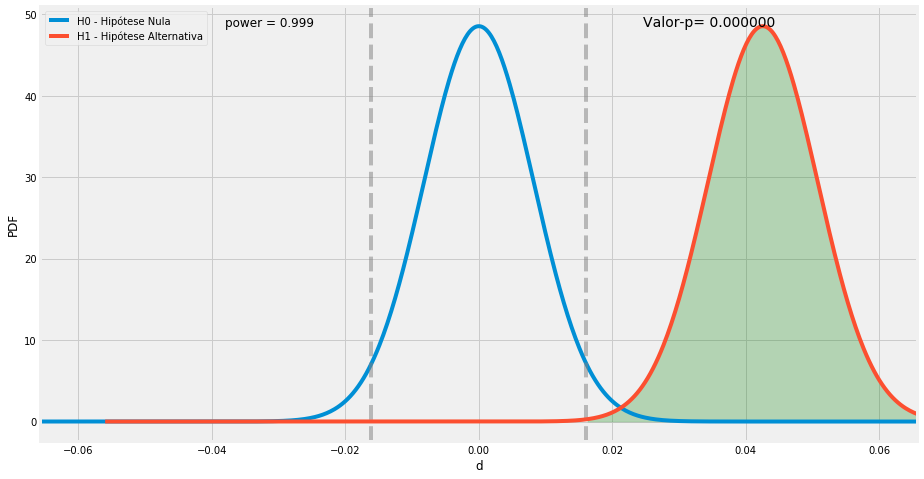

In [65]:
# Definir parâmetros e executar a função
n = n_A + n_B
conversao_base = p_A
d_hat = p_B - p_A
abplot_func(n_A, n_B, conversao_base, d_hat, show_p_value = True)

Observação do gráfico: Linha azul representa a distribuição normal para H0 e a linha vermelha, H1. Como as duas curvas têm formato idêntico, podemos comparar a distância entre as médias das duas distribuições.Podemos ver que a curva de hipótese alternativa sugere que o grupo de teste tem uma taxa de conversão maior do que o grupo de controle. Rejeitamos, portanto, a H0.
Este gráfico também pode ser usado para determinar diretamente o poder estatístico. O 'power' indicou 99% de certeza de que se removermos as avaliações da página, a conversão será maior.


### Passo 4: Calculando o poder estatístico

O poder estatítico é o grau de certeza sobre o resultado. A área sombreada em verde representa o poder estatístico e o valor calculado para o poder também é exibido no gráfico. As linhas tracejadas em cinza no gráfico acima representam o intervalo de confiança (95% para o gráfico acima) para a hipótese nula. O poder estatístico é calculado encontrando a área sob a distribuição de hipótese alternativa e fora do intervalo de confiança da hipótese nula.

### Passo 5: Avaliar como o tamanho das amostras afeta os Testes A/B

Os experimentos são normalmente configurados para uma potência mínima desejada de 80%. Sabe-se que, se aumentarmos o tamanho da amostra para cada grupo, diminuiremos a variância combinada para nossa hipótese nula e alternativa e assim aumenta o poder estatístico.

O tamanho da amostra está diretamente relacionado à rapidez com que podemos concluir os experimentos e fornecer resultados estatisticamente significativos. 

In [66]:
# Calculamos os valores de z alfa e beta
sig_level = 0.05
beta = 0.2
k = n_A/n_B
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(1-beta)
Z_alpha = standard_norm.ppf(1-sig_level)
print(Z_beta)
print(Z_alpha)

0.8416212335729143
1.6448536269514722


In [67]:
# Função para encontrar o tamanho mínimo da amostra
def calcula_tamanho_min_amostra(n_A, 
                                n_B, 
                                p_A, 
                                p_B, 
                                power = 0.8, 
                                sig_level = 0.05, 
                                two_sided = False):
   
    k = n_A/n_B
    
    # Distribuição normal para determinar os valores z
    standard_norm = scs.norm(0, 1)

    # Valor de z para o poder estatístico
    Z_beta = standard_norm.ppf(power)
    
    # Encontrar z alfa
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # Probabilidade agrupada
    pooled_prob = (p_A + p_B) / 2

    # Tamanho mínimo da amostra
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / efeito_min**2)    

    return min_N

In [68]:
# Tamanho mínimo da amostra com two_sided = True
calcula_tamanho_min_amostra(n_A, n_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)

1249.8068972849476

In [69]:
# Tamanho mínimo da amostra com two_sided = False
calcula_tamanho_min_amostra(n_A, n_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = False)

984.4720435225323

In [70]:
# Tamanho mínimo da amostra considerando a baseline
conversao_base + efeito_min

# Calcula a probabilidade agrupada
probabilidade_agrupada = (conversao_base + conversao_base + efeito_min)/ 2

# Soma de z alfa e beta
Z_beta + Z_alpha

min_N = (2 * probabilidade_agrupada * (1 - probabilidade_agrupada) * (Z_beta + Z_alpha)** 2/ efeito_min**2)
min_N

984.4720435225323

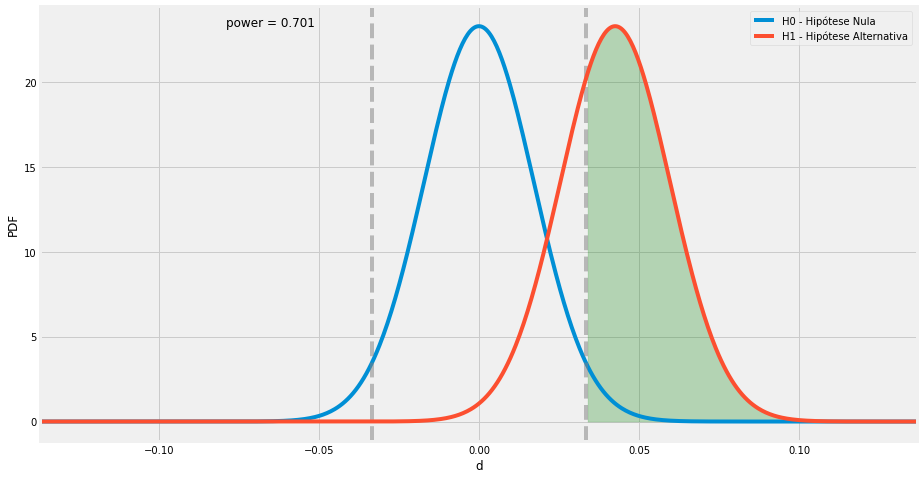

In [71]:
# Executa a função para 984 amostras
abplot_func(n_A = 984, n_B = 984, bcr = p_A, d_hat = p_B - p_A, sig_level = 0.05, show_p_value = False, show_legend = True)

Observação do gráfico: a alteração do tamanho da amostra para 984 registros indicou que o grupo B ainda geraria uma maior conversão porém podemos afirmar com apenas 70% de certeza, o que não é considerado ideal.

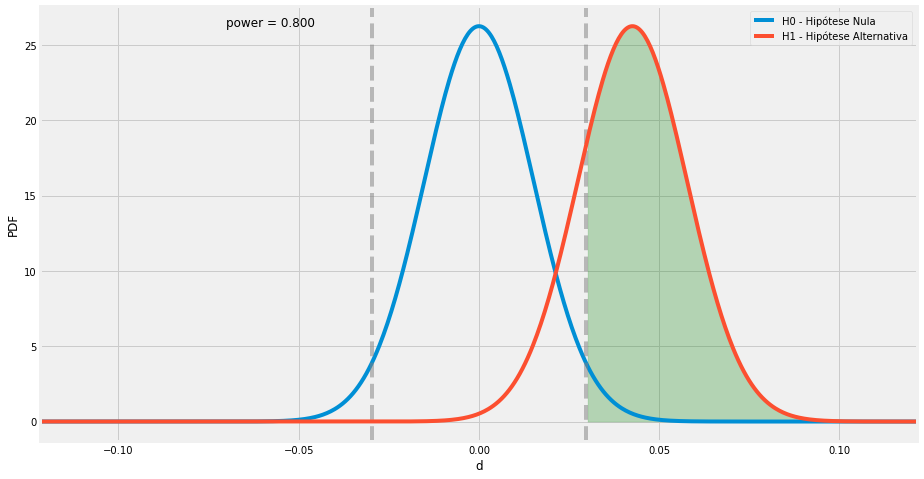

In [72]:
# Executa a função para 1249 amostras
abplot_func(n_A = 1249, n_B = 1249, bcr = p_A, d_hat = p_B - p_A, sig_level = 0.05, show_p_value = False, show_legend = True)

Observação do gráfico: O tamanho da amostra de 1249 indica que o grupo B gera uma maior conversão, e esse resultado é apresentado com um poder de certeza de 80%,  que é o ideal mínimo.

### Conclusão
O poder calculado para este tamanho de amostra foi de aproximadamente 0,80. Portanto, para afirmar que a mudança na página removendo as avaliações de usuários realmente aumentou a taxa de conversão precisamos de pelos menos 1249 amostras. Então, para o conjunto de dados acima, com 1249 amostras podemos afirmar que sim, remover as avaliações de usuários da página aumenta a taxa de conversão.